In [140]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import os 
from skimage.segmentation import slic
from sklearn.linear_model import Lasso
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr

# Load Resnet18

In [133]:
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set model to evaluation mode

# Define the image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]   
    )
])

# Load the ImageNet class index mapping
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
id2label = {v[0]: v[1] for v in class_idx.values()}

imagenet_path = './imagenet_samples'

# List of image file paths
image_paths = os.listdir(imagenet_path)



/home/jaakko/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jaakko/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Predict a sample of 5 images

In [134]:
imgs = []

for img_path in image_paths:
    # Open and preprocess the image
    my_img = os.path.join(imagenet_path, img_path)
    input_image = Image.open(my_img).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        input_batch = input_batch.to(device)
        model.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]

    print(f"Predicted label: {predicted_synset} ({predicted_label}) for image {img_path}")
    imgs.append((input_image, predicted_idx, img_path))


Predicted label: n01806143 (peacock) for image peacock.JPEG
Predicted label: n03792782 (mountain_bike) for image mountain_bike.JPEG
Predicted label: n03938244 (pillow) for image piggy_bank.JPEG
Predicted label: n04118776 (rule) for image paintbrush.JPEG
Predicted label: n03250847 (drumstick) for image mousetrap.JPEG



# Implement LIME

In [ ]:
def lime(model, image, preprocess, predicted_class, N=1000, K=10):
    """Generate LIME explanations for a given image and model.
    Based on: Ribeiro et al., "Why Should I Trust You?": Explaining the Predictions of Any Classifier
    2016. https://arxiv.org/abs/1602.04938
    """

    # Segment image into superpixels using SLIC: https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic
    image_np = np.array(image)
    segments = slic(image_np, n_segments=50)

    # Generate random binary masks to be used for perturbations
    num_features = np.max(segments) + 1
    data = np.random.randint(0, 2, size=(N, num_features))
    data[0, :] = 1 # Ensure we include the original image as it is

    # Generate perturbed images and collect predictions
    preds = []
    imgs = []
    batch_size=32
    for i, mask in enumerate(data):
        temp = image_np.copy()
        for j in range(num_features):
            if mask[j] == 0:
                temp[segments == j] = (128, 128, 128) # Gray out superpixel if mask is 0
        img_tensor = preprocess(Image.fromarray(temp)).unsqueeze(0)
        imgs.append(img_tensor)
        if len(imgs) == batch_size or i == N - 1:
            batch = torch.cat(imgs, dim=0).to(device)
            with torch.no_grad():
                output = model(batch)
            preds.extend(output[:, predicted_class].cpu().numpy())
            imgs = []

    preds = np.array(preds)

    # Similarity Kernel
    distances = euclidean_distances(data, data[0].reshape(1, -1)).ravel()
    kernel_width = 2
    weights = np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2))

    # Fit Lasso and limit to top-K features
    lasso = Lasso(alpha=0.01, max_iter=10000)
    lasso.fit(data, preds, sample_weight=weights)
    raw_weights = lasso.coef_
    top_k_indices = np.argsort(np.abs(raw_weights))[-K:]
    top_k_weights = np.zeros_like(raw_weights)
    top_k_weights[top_k_indices] = raw_weights[top_k_indices]

    return segments, top_k_weights

def visualize_lime(image, segments, lime_weights):
    # Gray out unimportant superpixels
    unimportant_indices = np.where(lime_weights == 0)[0]
    image_np = np.array(image)
    masked_image = image_np.copy()
    for idx in unimportant_indices:
        masked_image[segments == idx] = (128, 128, 128)

    # Visualize original and LIME explanation side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title(f"Predicted: {predicted_label}")
    axes[0].axis('off')
    axes[1].imshow(masked_image)
    axes[1].set_title(f"LIME: Top-10 Superpixels")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

# Run LIME on sample images


Predicted label: n01806143 (peacock) for image peacock.JPEG


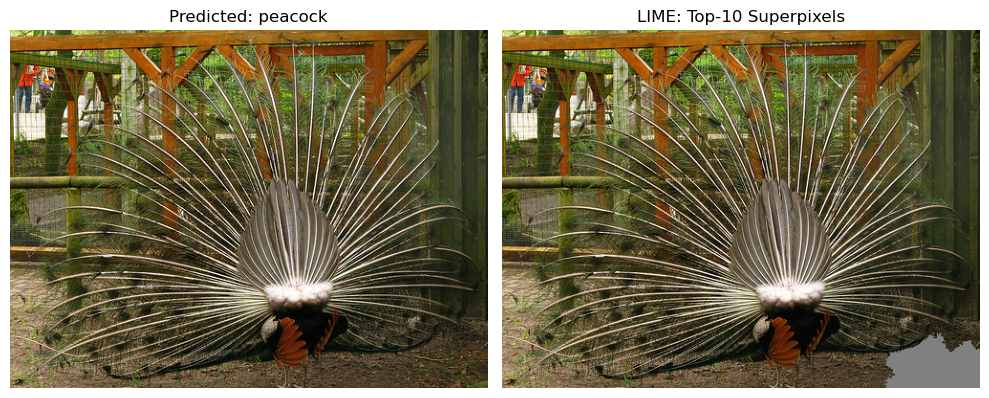


Predicted label: n03792782 (mountain_bike) for image mountain_bike.JPEG


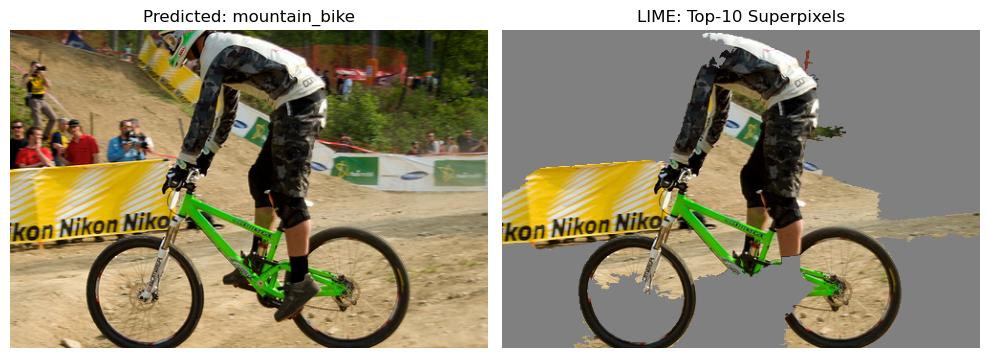


Predicted label: n03938244 (pillow) for image piggy_bank.JPEG


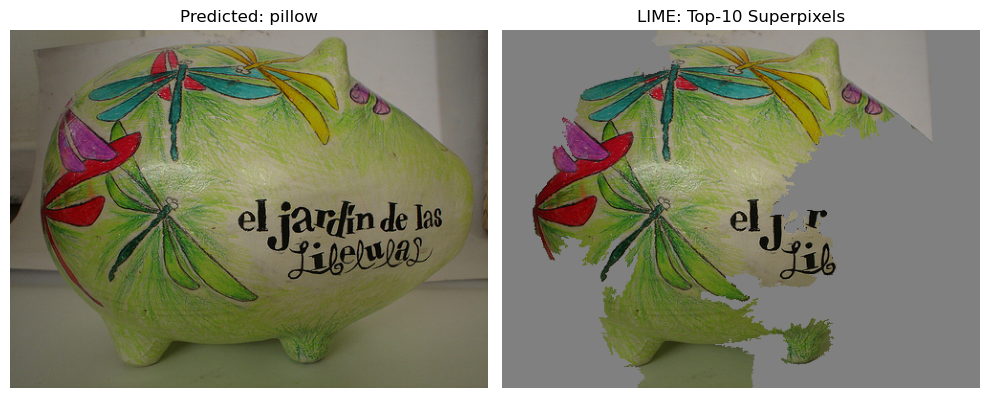


Predicted label: n04118776 (rule) for image paintbrush.JPEG


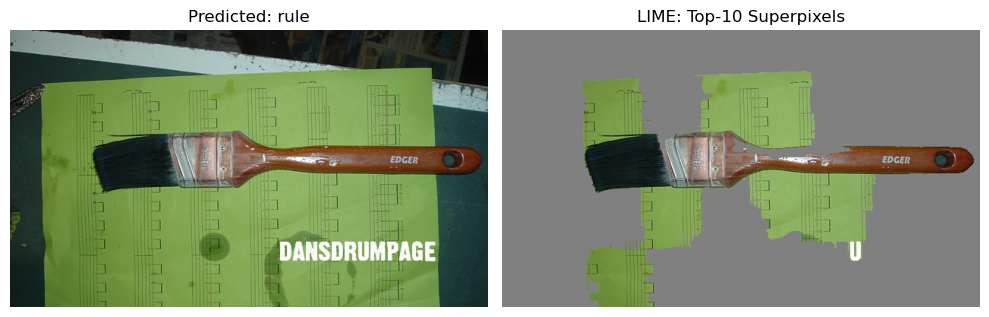


Predicted label: n03250847 (drumstick) for image mousetrap.JPEG


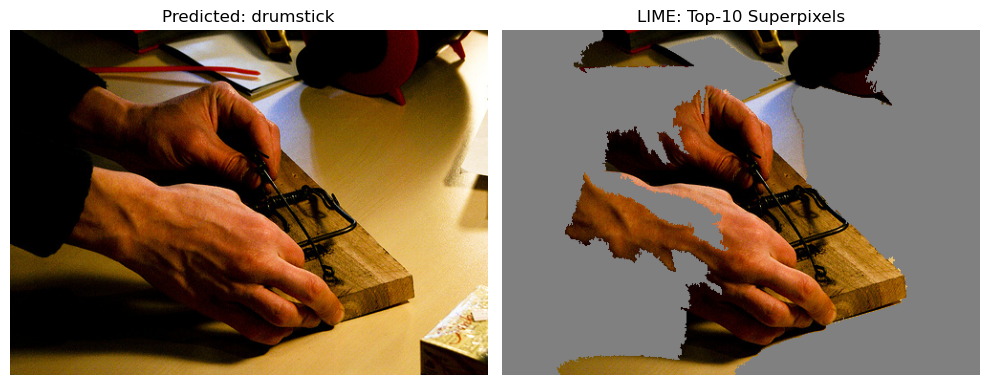

In [142]:
for image, predicted_idx, img_path in imgs:
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]
    print(f"\nPredicted label: {predicted_synset} ({predicted_label}) for image {img_path}")

    # Run LIME explanation
    segments, lime_weights = lime(model=model, image=image, preprocess=preprocess, predicted_class=predicted_idx, N=1000, K=10)
    visualize_lime(image, segments, lime_weights)

# Implement SmoothGrad

In [137]:
def smoothgrad(model, image, preprocess, target_class, n_samples=64, noise_level=0.15):
    """Compute SmoothGrad saliency map for a given image and model.
    Based on Smilkov et al., "SmoothGrad: removing noise by adding noise" https://arxiv.org/pdf/1706.03825"""

    # Preprocess and prepare input
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    # Compute gradients for n_samples noisy inputs
    grads = []
    for _ in range(n_samples):
        noise = torch.normal(mean=0, std=noise_level, size=input_tensor.shape).to(device)
        noisy_input = (input_tensor + noise).detach().requires_grad_()
        output = model(noisy_input)
        score = output[0, target_class]
        model.zero_grad()
        score.backward()
        grad = noisy_input.grad.detach().cpu().numpy()[0]
        grads.append(grad)

    # Average gradients
    avg_grad = np.mean(grads, axis=0)

    return avg_grad

def visualize_smoothgrad(image, avg_grad):
    # Get absolute values and saliency map
    abs_grad = np.abs(avg_grad)
    saliency = np.sum(abs_grad, axis=0)

    # Normalize to [0, 1]
    saliency = saliency - saliency.min()
    saliency = saliency / saliency.max()

    # Plot images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(saliency, cmap='gray')
    axes[1].set_title("SmoothGrad Saliency")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

# Run SmoothGrad on sample images


Predicted label: n01806143 (peacock) for image peacock.JPEG


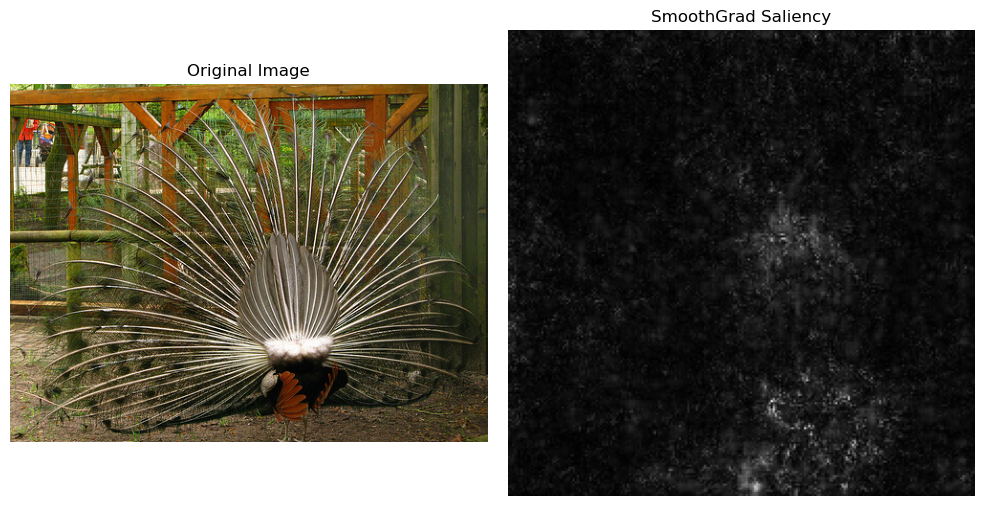


Predicted label: n03792782 (mountain_bike) for image mountain_bike.JPEG


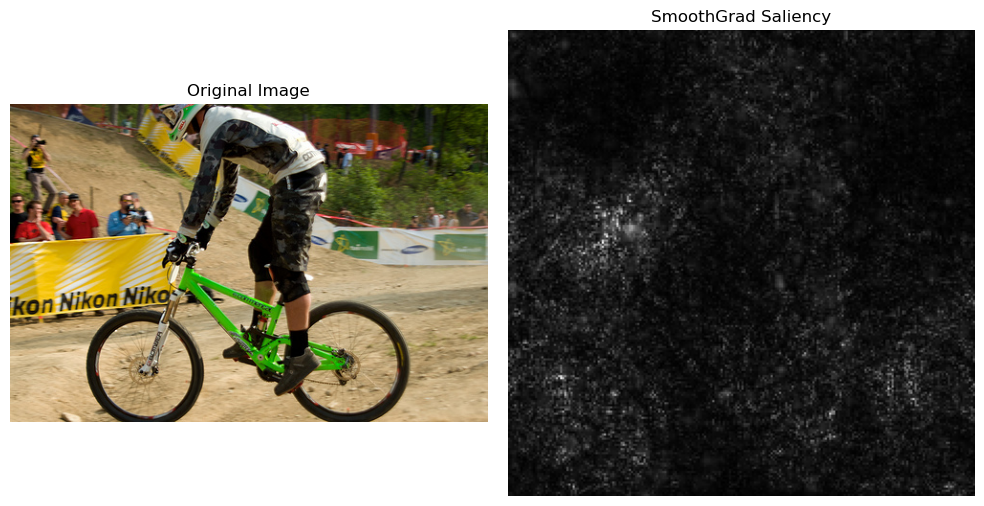


Predicted label: n03938244 (pillow) for image piggy_bank.JPEG


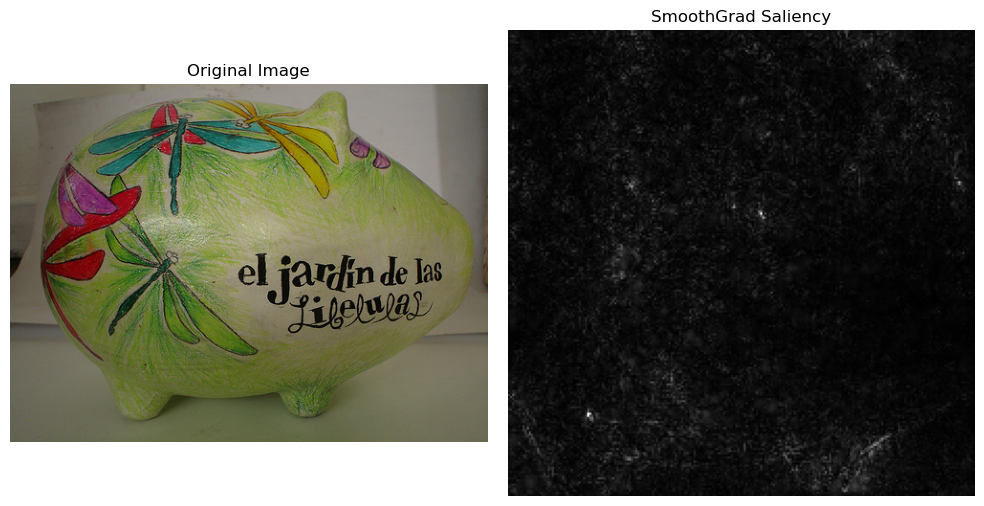


Predicted label: n04118776 (rule) for image paintbrush.JPEG


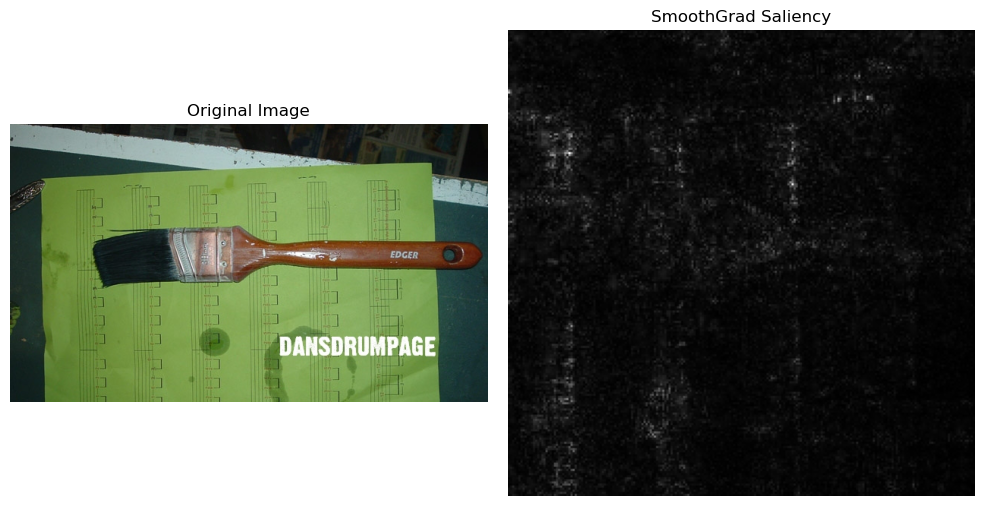


Predicted label: n03250847 (drumstick) for image mousetrap.JPEG


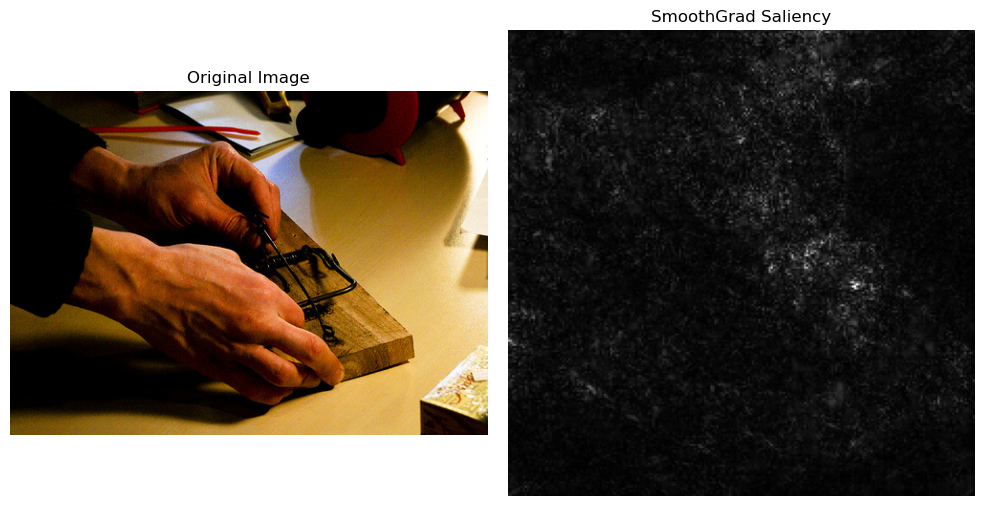

In [138]:
for image, predicted_idx, img_path in imgs:
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]
    print(f"\nPredicted label: {predicted_synset} ({predicted_label}) for image {img_path}")

    avg_grad = smoothgrad(model, image, preprocess, predicted_idx, n_samples=50, noise_level=0.15)
    visualize_smoothgrad(image, avg_grad)

# Compare feature rankings statistically

In [139]:
for image, predicted_idx, img_path in imgs:
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]
    print(f"\nPredicted label: {predicted_synset} ({predicted_label}) for image {img_path}")

    # Get LIME explanations
    segments, lime_weights = lime(model, image, preprocess, predicted_idx, N=1000, K=10)
    
    # Get SmoothGrad saliency map
    avg_grad = smoothgrad(model, image, preprocess, predicted_idx, n_samples=50, noise_level=0.15)
    saliency = np.sum(np.abs(avg_grad), axis=0)

    # Get mean of SmoothGrad saliency pixels within superpixels
    # First need to resize segments to saliency shape and flip shape since saliency shape is (H, W) after preprocessing
    segments_resized = np.array(Image.fromarray(segments.astype(np.int32)).resize(saliency.shape[::-1], resample=Image.NEAREST))
    super_pixel_labels = np.unique(segments_resized)
    num_superpixels = np.max(super_pixel_labels) + 1
    smoothgrad_importance = np.zeros(num_superpixels)
    for label in super_pixel_labels:
        smoothgrad_importance[label] = saliency[segments_resized == label].mean()

    # Compute rank correlations
    lime_ranks = np.argsort(-np.abs(lime_weights))
    smoothgrad_ranks = np.argsort(-np.abs(smoothgrad_importance))

    kendall_corr, _ = kendalltau(lime_ranks, smoothgrad_ranks)
    spearman_corr, _ = spearmanr(lime_ranks, smoothgrad_ranks)

    print(f"Kendall Tau: {kendall_corr:.3f}, Spearman: {spearman_corr:.3f}")




Predicted label: n01806143 (peacock) for image peacock.JPEG
Kendall Tau: 0.067, Spearman: 0.079

Predicted label: n03792782 (mountain_bike) for image mountain_bike.JPEG
Kendall Tau: 0.149, Spearman: 0.228

Predicted label: n03938244 (pillow) for image piggy_bank.JPEG
Kendall Tau: -0.101, Spearman: -0.144

Predicted label: n04118776 (rule) for image paintbrush.JPEG
Kendall Tau: -0.114, Spearman: -0.140

Predicted label: n03250847 (drumstick) for image mousetrap.JPEG
Kendall Tau: -0.168, Spearman: -0.253
